<center><img src="https://pbs.twimg.com/media/FommiJ9WIAEBPI0.jpg" width="500" /></center>
    
 <center> 

# Fase local
## Script de exploración - Equipo **Malbecs**

</center>

**Integrantes**

- Denis Trosman
- Vito Stamatti
- Sumit Kumar Jethani

# Objetivo

España es el tercer productor mundial de vino. Disponer de una previsión precisa de la producción en una campaña agrícola es cada vez más necesario de cara a optimizar todos los procesos de la cadena: recolección, traslado, procesado, almacenamiento y distribución.

Dado lo anterior y partiendo de amplios datasets con histórico de producciones de los viñedos que conforman la cooperativa La Viña, así como histórico de la climatología de los mismos, intentaremos crear el mejor modelo de predicción de producción de una campaña en base al cual se pueda estimar la cosecha que dispondrá la cooperativa meses antes de la recolección.

El primer paso será realizar un análisis exploratorio de los datos.

Recordemos que contamos con tres datasets:

- Train: datos históricos de las fincas.
- Meteo: datos por hora del clima.
- ETO: datos agregados del clima.

Por este motivo, el análisis exploratorio será dividido en tres partes, respectivamente.

# Importacion de librerias

In [1]:
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)  
import numpy as np

import warnings
warnings.filterwarnings('ignore')

#Data viz
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
plt.rcParams['axes.facecolor'] = 'white'

# Train

El dataset contiene informacion de las siguientes variables sobre las fincas de los viñedos:

- CAMPAÑA: Año de la campaña.
- ID_FINCA: Identificador de finca.
- ID_ZONA: Identificador de una zona con una tipología de suelo común
- ID_ESTACION: Identificador de estación meteorológica.
- ALTITUD: Altitud media de la finca sobre el nivel del mar en metros.
- VARIEDAD: Código de variedad de la uva que se cultiva en la finca.
- MODO: Código del modo de cultivo.
- TIPO: Tipo de cultivo dentro de la variedad.
- COLOR: Identificador del color de la uva.
- SUPERFICIE: Superficie en hectáreas que ocupa la finca.
- PRODUCCION: Producción en kg. Obtenida en la campaña.

## Exploración inicial

Carga de datos

In [2]:
path = 'C:/Users/denis/OneDrive/Escritorio/Datathon/datos'
df = pd.read_csv(path + '/UH_2023_TRAIN.txt', sep= '|', header=0 )

Primera visualización

In [3]:
df.head()

,CAMPAÑA,ID_FINCA,ID_ZONA,ID_ESTACION,ALTITUD,VARIEDAD,MODO,TIPO,COLOR,SUPERFICIE,PRODUCCION
0,14,76953,515,4,660,26,2,0,1,0.00,22215.00
1,14,84318,515,4,660,26,2,0,1,0.00,22215.00
2,14,85579,340,4,520,32,2,0,1,0.00,20978.00
3,14,69671,340,4,520,32,2,0,1,0.00,40722.00
4,14,14001,852,14,NaN,81,1,0,1,0.00,14126.00


Ajustamos nombres de columnas bajo buenas prácticas

In [4]:
df.columns = [col.lower() for col in df.columns]

Resumen general de los datos

In [5]:
print(f'Número de filas: {df.shape[0]}, Número de columnas:{df.shape[1]}')
print(f'\nCantidad de duplicados: {df.duplicated().sum()}\n')
print('-'*30 + 'Tipos de columnas'+ '-'*30)
print(df.dtypes)
print('-'*30 + 'Cantidad de nulos' +'-'*30)
df.isna().sum()

Número de filas: 9601, Número de columnas:11

Cantidad de duplicados: 0

------------------------------Tipos de columnas------------------------------
campaña          int64
id_finca         int64
id_zona          int64
id_estacion      int64
altitud         object
variedad         int64
modo             int64
tipo             int64
color            int64
superficie     float64
produccion     float64
dtype: object
------------------------------Cantidad de nulos------------------------------


campaña           0
id_finca          0
id_zona           0
id_estacion       0
altitud          54
variedad          0
modo              0
tipo              0
color             0
superficie        0
produccion     1075
dtype: int64

Observamos si hay concentración de valores o valores que deberian ser NaN

- **Superficie**: presencia de 0s que deben ser codíficados como NaN
- **Altitud**: puede transformarse a númerica considerando valor medio de los rangos
- **Campaña**: no todos los años hay la misma cantidad de fincas
- **Tipo**: valor altamente desbalanceado (99%)
- **Columnas IDs**: las columnas id_finca, id_zona e id_estacion estan como númericas

In [6]:
def valores_unicos(df,columna):
    data_frame = pd.DataFrame(df[columna].value_counts())
    data_frame['share']=data_frame[columna]/sum(data_frame[columna])*100 
    data_frame= data_frame.reset_index()
    data_frame.columns = [columna,'count','share %']
    return data_frame

#Funcion para mostrar DataFrames lado por lado
#fuente: https://stackoverflow.com/questions/38783027/jupyter-notebook-display-two-pandas-tables-side-by-side

from IPython.display import display_html
from itertools import chain,cycle

def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'Columna: {title}\n'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

In [7]:
for col in df.columns:
    display_side_by_side(valores_unicos(df,col).head(),
                         titles = [col])

,campaña,count,share %
0,14,1148,11.96
1,15,1116,11.62
2,16,1079,11.24
3,22,1075,11.20
4,18,1061,11.05


,id_finca,count,share %
0,4024,59,0.61
1,49636,54,0.56
2,48827,47,0.49
3,84174,46,0.48
4,61177,36,0.37


,id_zona,count,share %
0,441,703,7.32
1,272,419,4.36
2,134,406,4.23
3,464,378,3.94
4,510,283,2.95


,id_estacion,count,share %
0,12,2060,21.46
1,5,1155,12.03
2,7,1113,11.59
3,16,1087,11.32
4,15,956,9.96


,altitud,count,share %
0,455-470,703,7.36
1,650-660,680,7.12
2,455-465,431,4.51
3,630-640,430,4.50
4,600-670,419,4.39


,variedad,count,share %
0,59,2770,28.85
1,17,2167,22.57
2,32,974,10.14
3,52,611,6.36
4,81,568,5.92


,modo,count,share %
0,2,4891,50.94
1,1,4710,49.06


,tipo,count,share %
0,0,9483,98.77
1,1,118,1.23


,color,count,share %
0,1,8097,84.33
1,0,1504,15.67


,superficie,count,share %
0,0.00,6518,67.89
1,1.85,14,0.15
2,2.11,12,0.12
3,0.78,12,0.12
4,0.43,11,0.11


,produccion,count,share %
0,2260.00,10,0.12
1,2950.00,10,0.12
2,3520.00,9,0.11
3,1970.00,9,0.11
4,2670.00,9,0.11


Cantidad de valores únicos por columna

In [8]:
df.nunique(axis=0)

campaña           9
id_finca       1231
id_zona         125
id_estacion      20
altitud          84
variedad         25
modo              2
tipo              2
color             2
superficie     1212
produccion     6287
dtype: int64

## Visualización de variables

Comenzamos visualizando aquellas variables continuas:

- Superficie (convirtiendo 0s a NaN)
- Producción
- Altitud (ajustada a númerica)

Ajustamos altitud, convirtiendo aquellos valores de rango al valor medio de sus puntas, a través de la función **transform_altitud**.

In [9]:
def transform_altitud(alt):
    if type(alt) is str:
        alt_list = alt.split("-")
        alt_list = list(map(float, alt_list))
        return np.mean(alt_list) 
    return alt

In [10]:
df['altitud'] = df['altitud'].apply(lambda alt: transform_altitud(alt))

In [11]:
df['superficie'] = df['superficie'].replace(0, np.nan)

Producción por año

- Los años 2014 y 2017 son aquellos con menor producción
- 2015, 2018, los mas altos

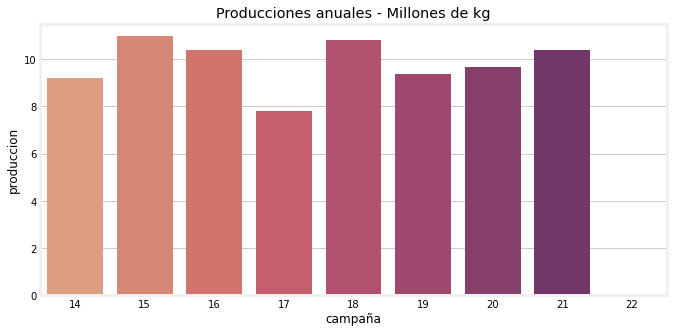

In [12]:
prod_anual = df.groupby('campaña')['produccion'].sum().reset_index()
prod_anual['produccion'] = prod_anual.produccion/1000000

plt.figure(facecolor="white", figsize=(10,5))
sns.barplot(data=prod_anual,x='campaña',y='produccion', palette= 'flare')
plt.title('Producciones anuales - Millones de kg')
plt.show()

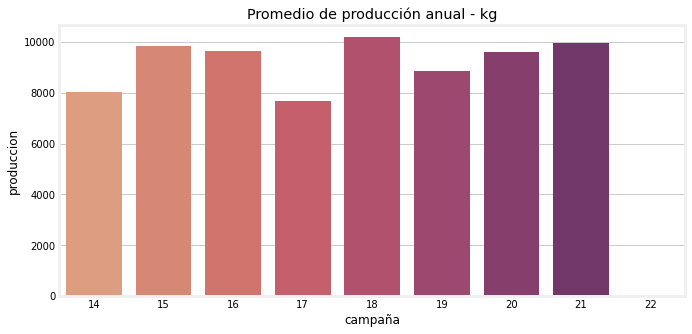

In [13]:
plt.figure(facecolor="white", figsize=(10,5))
sns.barplot(data=df.groupby('campaña')['produccion'].mean().reset_index(),x='campaña',y='produccion', palette= 'flare')
plt.title('Promedio de producción anual - kg')
plt.show()

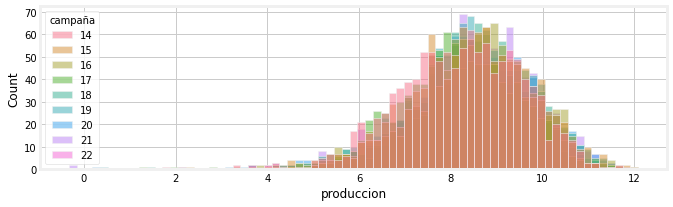

In [14]:
plt.figure(figsize=(10,3))
sns.histplot(
    df.assign(
        produccion = lambda df: np.log(df['produccion']),
        campaña = lambda df: df['campaña'].astype(str)
    ), 
    x='produccion', 
    hue='campaña'
)
plt.show()

Box-plots

- Contamos con valores atípicos a simple vista, para producción y superficie

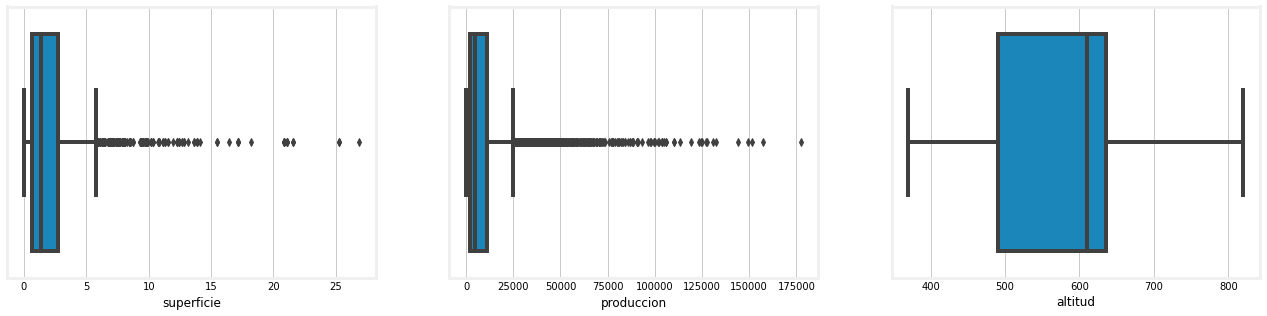

In [15]:
cont_vars = ['superficie', 'produccion', 'altitud']
fig, axes = plt.subplots(ncols=3, figsize=(20, 5))
sns.boxplot(x=df[df['superficie']>0]['superficie'], ax=axes[0])
sns.boxplot(x=df['produccion'], ax=axes[1])
sns.boxplot(x=df['altitud'], ax=axes[2])
plt.show()

Relaciones entre variables continuas

- Aunque Train tenga la totalidad de sus columnas númericas, solo tomamos aquella cuya naturaleza tambien lo es
- Correlación fuerte entre superficie y produccion

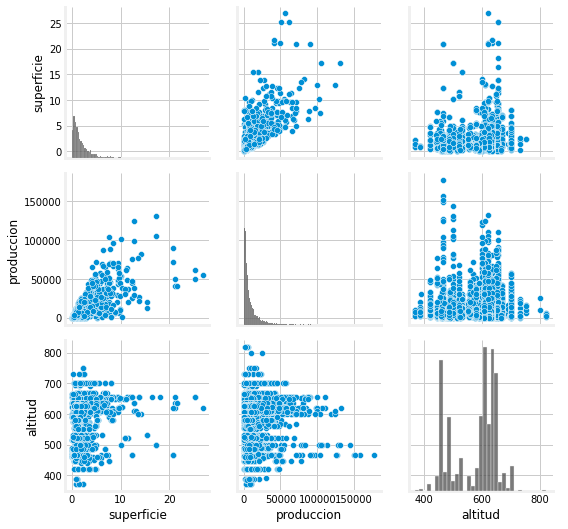

In [16]:
g = sns.PairGrid(df[cont_vars])
g.map_diag(sns.histplot, hue=None, color=".3")
g.map_offdiag(sns.scatterplot)
g.add_legend()
plt.show()

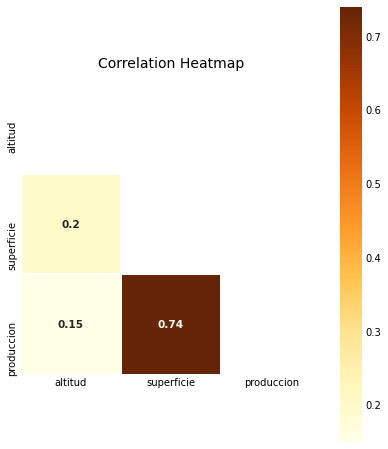

In [17]:
def Generate_heatmap_graph(corr, chart_title, mask_uppertri=False ):
    
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = mask_uppertri
    fig,ax = plt.subplots(figsize=(6,8))
    ax.set_facecolor('white')
    sns.heatmap(corr
                , mask = mask
                , square = True
                , annot = True
                , annot_kws={'size': 10.5, 'weight' : 'bold'}
                , cmap=plt.get_cmap("YlOrBr")
                , linewidths=.1)
    plt.title(chart_title, fontsize=14)

    plt.show()
    

var_corr = round(df[['altitud','superficie','produccion']].corr(),2)
Generate_heatmap_graph(var_corr
                       ,chart_title = 'Correlation Heatmap'
                       ,mask_uppertri = True)

Producción y superficie según variables binarias

- Vemos que el tipo 0 tiene picos mas altos que el 1 para produccion
- El color 0, picos mas bajos que el 1 tanto para produccion como superficie

In [18]:
def plot_by(col):
    fig, axes = plt.subplots(1, 3, figsize=(10,7), sharey=True)
    fig.suptitle(f'{col.capitalize()} según tipo, color y modo')

    sns.violinplot(data=df, x='tipo', y=col, ax=axes[0], palette='Blues_r')
    sns.violinplot(data=df, x='color', y=col, ax=axes[1], palette='Blues_r')
    sns.violinplot(data=df, x='modo', y=col, ax=axes[2], palette='Blues_r')
    plt.show()

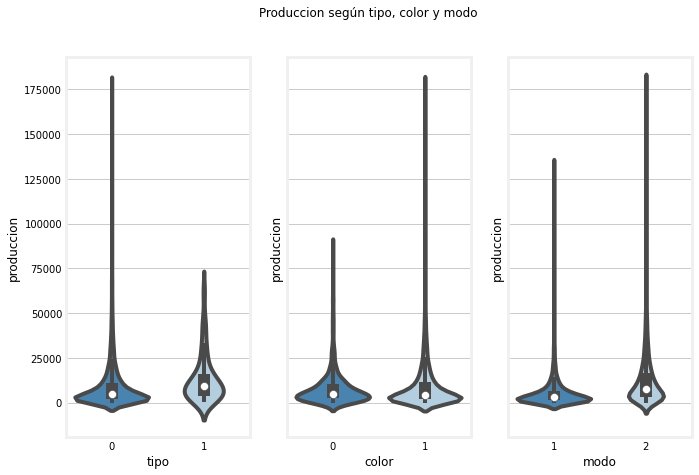

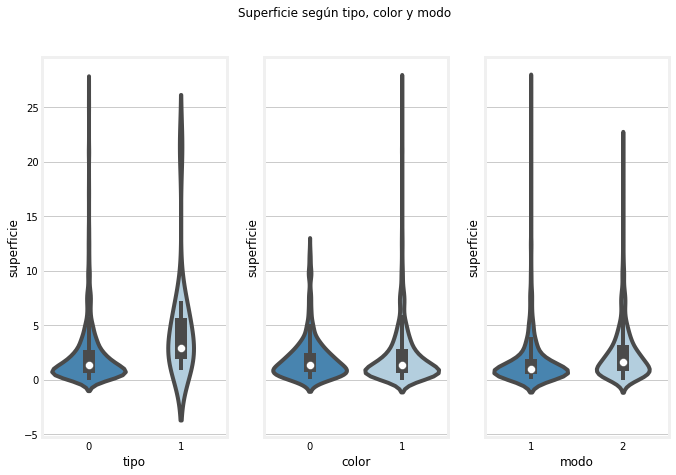

In [19]:
plot_by('produccion')
plot_by('superficie')

Producciones y superficies según ids

- Variedades

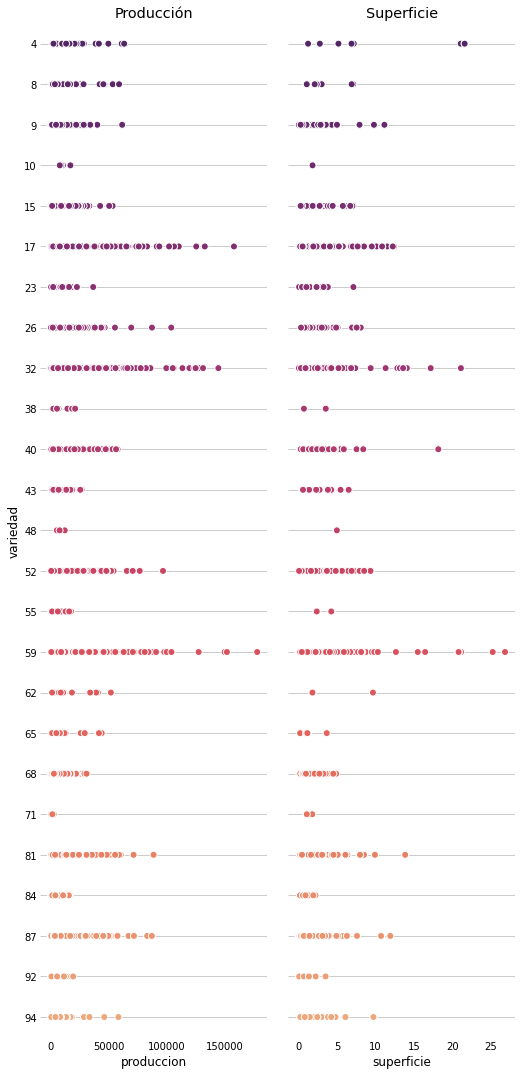

In [20]:
g = sns.PairGrid(df,
                 x_vars=['produccion','superficie'], y_vars=["variedad"],
                 height=15, aspect=.25)

g.map(sns.stripplot, size=7, orient="h", jitter=False,
      palette="flare_r", linewidth=1, edgecolor="w")

titles = ["Producción", "Superficie"]

for ax, title in zip(g.axes.flat, titles):

    ax.set(title=title)

    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)

- Estacion

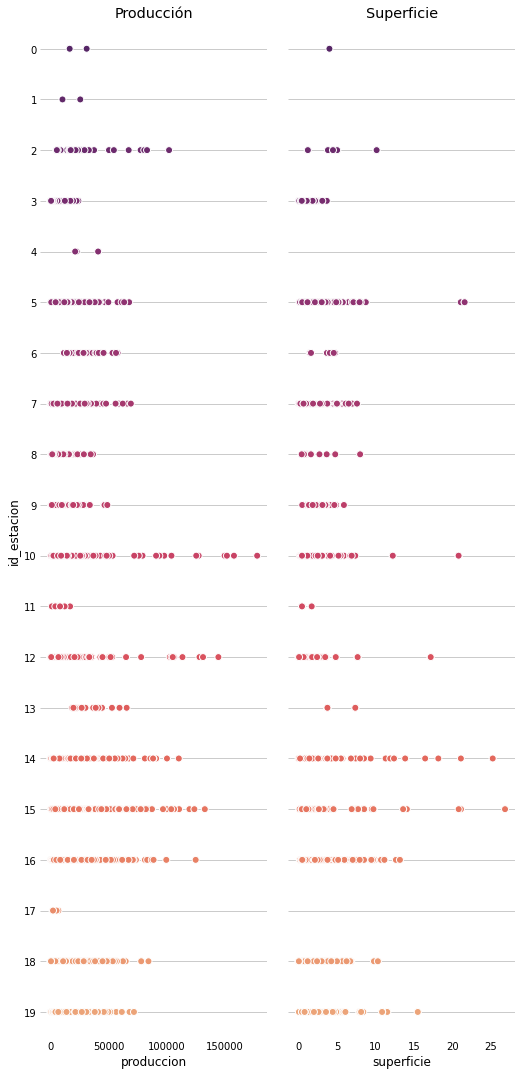

In [21]:
g = sns.PairGrid(df,
                 x_vars=['produccion','superficie'], y_vars=["id_estacion"],
                 height=15, aspect=.25)

g.map(sns.stripplot, size=7, orient="h", jitter=False,
      palette="flare_r", linewidth=1, edgecolor="w")

titles = ["Producción", "Superficie"]

for ax, title in zip(g.axes.flat, titles):

    ax.set(title=title)

    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)

## Análisis sobre variación de producción y superficies anuales

Estudiamos las variaciones de la produccion de año a año.

Para eso:

- Creamos funcion para obtener el valor del año anterior de la columna deseada.
- Creamos funcion para obtener la diferencia entre el valor actual y el pasado de la columna deseada, una vez ejecutada la funcion anterior.
- Aplicamos a una copia del dataframe original y visualizamos aquellos cambios más bruscos
- Visualizamos

In [22]:
def crear_shift(df,col):
    df = df.copy()
    df[f'{col}_t-1'] = df.groupby(['id_finca','variedad','modo'])[col].shift()
    df[f'{col}_t-2'] = df.groupby(['id_finca','variedad','modo'])[f'{col}_t-1'].shift()
    return df

In [23]:
def crear_diferencias(df,col):
    df = df.copy()
    df[f'dif_{col}'] = abs(df[f'{col}_t-1']-df[col])
    return df

In [24]:
df_shift = df.copy()
df_shift = crear_shift(df_shift,'produccion')
df_shift = crear_shift(df_shift,'superficie')
df_shift = crear_diferencias(df_shift,'produccion')
df_shift = crear_diferencias(df_shift,'superficie')
df_shift = df_shift.dropna(subset=['dif_produccion','dif_superficie'])

In [25]:
df_shift.sort_values('dif_produccion',ascending=False).head()

,campaña,id_finca,id_zona,id_estacion,altitud,variedad,modo,tipo,color,superficie,produccion,produccion_t-1,produccion_t-2,superficie_t-1,superficie_t-2,dif_produccion,dif_superficie
7567,21,37826,964,2,500.00,17,2,0,1,10.15,101750.00,54260.00,82800.00,10.15,NaN,47490.00,0.00
7684,21,14843,845,16,647.50,62,2,0,0,9.67,51708.18,6862.40,18236.83,9.67,NaN,44845.78,0.00
8409,21,93922,50,19,567.50,87,2,0,0,4.92,71550.00,29700.00,49510.00,4.92,NaN,41850.00,0.00
7976,21,10376,513,18,622.50,59,2,0,1,10.31,38093.10,1351.23,33570.97,10.31,NaN,36741.87,0.00
8049,21,76459,510,15,600.00,26,2,0,1,7.54,69200.00,103610.00,44520.00,7.54,NaN,34410.00,0.00


In [26]:
df_shift.sort_values('dif_superficie',ascending=False).head()

,campaña,id_finca,id_zona,id_estacion,altitud,variedad,modo,tipo,color,superficie,produccion,produccion_t-1,produccion_t-2,superficie_t-1,superficie_t-2,dif_produccion,dif_superficie
7596,21,3091,379,16,620.00,81,1,0,1,3.92,21433.20,11225.35,28248.56,9.93,NaN,10207.85,6.01
8067,21,95678,144,15,620.00,59,1,0,1,26.85,55520.00,41630.00,80810.00,21.12,NaN,13890.00,5.73
7673,21,797,845,16,647.50,59,1,0,1,7.51,11710.00,6950.00,29040.00,3.36,NaN,4760.00,4.16
8072,21,85984,144,15,620.00,59,2,0,1,8.28,32086.14,19279.98,18456.12,4.38,NaN,12806.16,3.90
8501,21,69003,349,19,455.00,59,1,0,1,5.88,26710.00,12250.00,25190.00,2.46,NaN,14460.00,3.41


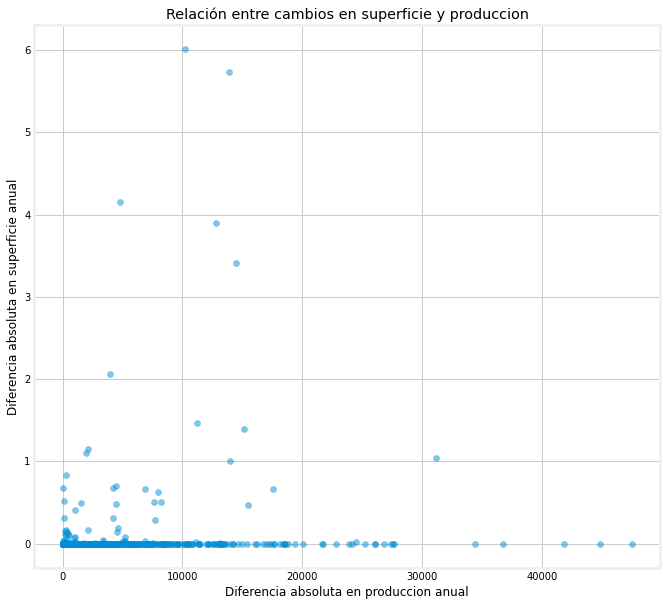

In [27]:
plt.figure(figsize=(10,10))
plt.scatter(x=df_shift.dif_produccion, y=df_shift.dif_superficie , alpha=0.5)
plt.xlabel('Diferencia absoluta en produccion anual')
plt.ylabel('Diferencia absoluta en superficie anual')
plt.title('Relación entre cambios en superficie y produccion')
plt.show()

Notamos que no hay una relación directa entre cambios en la producción y cambios en la superficie año a año, sino que una finca puede duplicar su producción sin haber cambiado su superficie.

## Imputacion de datos faltantes

Contamos con NAs en:

- altitud
- superficie
- produccion

Los NA en produccion son los que hay que predecir, por lo que no serán imputados

In [29]:
df.isna().sum()

campaña           0
id_finca          0
id_zona           0
id_estacion       0
altitud          54
variedad          0
modo              0
tipo              0
color             0
superficie     6518
produccion     1075
dtype: int64

Para altitud, reemplazamos por la media de la estacion, ya que una estacion tiene una sola altura y la relacion suele ser 1 a 1 con las fincas

In [30]:
df['altitud'] = df.groupby('id_estacion')['altitud'].transform(lambda x: x.fillna(x.mean()))

Para superficie, recordar que previamente reemplazamos los valores 0 por NAs, ya que asi venian los que no tenian datos. 

Para imputarlos, iremos calculando la media por mayor a menor desagregacion de los ids, hasta que no quede ninguno.

In [31]:
df['superficie'] = df.groupby(['id_finca','variedad','modo'])['superficie'].transform(lambda x: x.fillna(x.mean()))
df['superficie'] = df.groupby(['id_zona','variedad','modo'])['superficie'].transform(lambda x: x.fillna(x.mean()))
df['superficie'] = df.groupby(['id_estacion','variedad','modo'])['superficie'].transform(lambda x: x.fillna(x.mean()))
df['superficie'] = df.groupby(['variedad','modo'])['superficie'].transform(lambda x: x.fillna(x.mean()))
df['superficie'] = df.groupby(['variedad'])['superficie'].transform(lambda x: x.fillna(x.mean()))

df.superficie.isna().sum()

0

## Feature engineering

Creamos funciones para generar variables nuevas, siempre atentos a no realizar data leakage

- df_for_fe: dataframe para feature engineering, sin el año 21
- above_mean_col: variable que indique si para X valor de si una columna, la produccion fue mayor o menor a la media
- quantiles_col: parecida a la anterior, que indique si el id de la finca u otro id tiene una produccion en X quantil.

In [28]:
def df_for_fe(data):
    transf = data[data.campaña != 21]
    return transf

def above_mean_col(data,col):
    df = df_for_fe(data)
    above_mean = pd.DataFrame(df.groupby(col)['produccion'].mean() > df.produccion.mean())
    above_mean = list(above_mean[above_mean['produccion']].index)
    data[f'{col}_above_mean'] = [1 if x in above_mean else 0 for x in data[col]]
    return data

def quantiles_col(data,col):
    df = df_for_fe(data)
    quantiles_df = pd.DataFrame(df.groupby(col)['produccion'].mean()).reset_index()
    Q1 = quantiles_df.produccion.quantile(0.25)
    Q2 = quantiles_df.produccion.quantile(0.5)
    Q3 = quantiles_df.produccion.quantile(0.75)
    
    quantiles_df[f'{col}_percentiles'] = [0 if x < Q1 else 1 if x < Q2 else 2 if x < Q3 else 3 for x in quantiles_df.produccion]

    data = data.merge(quantiles_df[[col,f'{col}_percentiles']], how='left', on = col) #Joineamos con el df transformado
    
    return data

Aplicamos above_mean_col para altitud y variedad, y quantiles_col a finca y zona

In [32]:
for col in ['altitud','variedad']:
    df=above_mean_col(df,col)
    
for col in ['id_finca','id_zona']:
    df=quantiles_col(df,col)

El resultado de esto se ve en las ultimas 4 columnas del dataframe actualizado:

In [33]:
df.head()

,campaña,id_finca,id_zona,id_estacion,altitud,variedad,modo,tipo,color,superficie,produccion,altitud_above_mean,variedad_above_mean,id_finca_percentiles,id_zona_percentiles
0,14,76953,515,4,660.00,26,2,0,1,2.64,22215.00,0,1,3.00,3
1,14,84318,515,4,660.00,26,2,0,1,2.64,22215.00,0,1,3.00,3
2,14,85579,340,4,520.00,32,2,0,1,2.91,20978.00,1,1,3.00,3
3,14,69671,340,4,520.00,32,2,0,1,2.91,40722.00,1,1,3.00,3
4,14,14001,852,14,659.10,81,1,0,1,2.82,14126.00,1,0,3.00,1


Reemplazamos los pocos valores faltantes que resultan de la funcion quantiles_col

In [34]:
df['id_finca_percentiles'] = df.id_finca_percentiles.fillna(df_for_fe(df).id_finca_percentiles.mean())

# Meteo

# ETO

# Estrategias y modelos descartados